Almost every day we go online we encounter recommender systems; if you are listening to your favorite song on Spotify, binge watching a TV show on Netflix or buying a new laptop on Amazon. Although we all know these recommendation engines exist, it is less known what algorithms lie behind such recommendations. 
To get a better understanding of the algorithms used in recommender systems we decided to build a recommender ourselves! With COVID-19 making us more housebound than ever, a topic for our recommendation engine was quickly found; we decided to build a book recommender using Python. 
Although there are ready-to-use packages to build recommender systems (such as Surprise) <b> we decided to built or own recommendation system. </b> We did this because our goal was to understand how a recommendation engine works rather than just have a book recommender. Moreover, we wanted to be able to control the specifications of the variables used in our engine and wanted to avoid the black box. 
<b> In this notebook we explain step-by-step how we built our recommendation engine. </b> 

Our notebook contains of the following steps: 

!['processing flow'](https://bhciaaablob.blob.core.windows.net/cmotionsnlpblogs/stappenplan.png)

#### Data

A lot of recommenders have been build using English data sources such as the data scrapped from goodreads.com. We decided that we will use a new source and create a Dutch recommender instead. The data that we are using was obtained from a Dutch book review website. The source data is not made available. We obtained two data files: book data and rating data. 
The book table includes the information about the book itself such as:
- the name of the book, 
- the author of the book 
- book_id 

The ratings table consists of the scores that  users gave to the book. It includes:
- the book_id
- user url (unique per person) 
- the rating (ranging from 1, <i>did not like the book</i> to 5, <i>loved the book</i>). 

We will need to combine the two tables in order to build our recommender.

In [0]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #creating 
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from ftfy import fix_text
import hashlib  #to hash personal data
from six import ensure_binary #to hash personal data

In [0]:
# import ratings and books data into dataframes 
books = spark.sql("select * from bookies_txt").toPandas()
ratings = spark.sql("select * from reviewies_txt").toPandas()

In [0]:
#Hashing personal data
ratings.Reviewer_url = ratings.Reviewer_url.apply(ensure_binary).apply(lambda x: hashlib.md5(x).hexdigest())

In [0]:
books.head()

Out[45]:

Book_id 
 Book_url 
 Book_name 
 Author_url 
 Author_name 
 Publish_date 
 
 
 
 
 0 
 286 
 "https://www.hebban.nl/boek/maus-2-en-hier-be... 
 "Maus II" 
 "https://www.hebban.nl/auteur/art-spiegelman" 
 "Art Spiegelman" 
 "2000-08-28T00:00:00+02:00" 
 
 
 1 
 287 
 "https://www.hebban.nl/boek/maanpaleis-paul-a... 
 "Maanpaleis" 
 "https://www.hebban.nl/auteur/paul-auster" 
 "Paul Auster" 
 "1900-01-01T00:00:00+00:19" 
 
 
 2 
 289 
 "https://www.hebban.nl/boek/new-york-trilogie... 
 "De New York-trilogie" 
 "https://www.hebban.nl/auteur/paul-auster" 
 "Paul Auster" 
 "1900-01-01T00:00:00+00:19" 
 
 
 3 
 296 
 "https://www.hebban.nl/boek/don-juan-byron" 
 "Don Juan" 
 "https://www.hebban.nl/auteur/lord-byron" 
 "Lord Byron" 
 "1900-01-01T00:00:00+00:19" 
 
 
 4 
 299 
 "https://www.hebban.nl/boek/mansfieldpark-jan... 
 "Mansfield Park" 
 "https://www.hebban.nl/auteur/jane-austen" 
 "Jane Austen" 
 "1899-11-30T00:00:00+00:19"

In [0]:
ratings.head()

Out[46]:

Book_id 
 Rating 
 Reviewer_url 
 
 
 
 
 0 
 286 
 "4" 
 a2e060012923a7ac0fb56169e7acecb6 
 
 
 1 
 286 
 "4" 
 ba10aee9112573177a5f3b5b2d588096 
 
 
 2 
 286 
 "5" 
 c4f18d12c0c861a74c313a72b522c0d5 
 
 
 3 
 286 
 "5" 
 1c2b6714dddf5a947605dc0d06d575a0 
 
 
 4 
 286 
 "5" 
 e740a61c06b92d256cdc19ee01487c4d

However, prior to merging the books' data with the ratings we investigate whether or not books are rated more than once. If the book is rated only by 1 or 2 people it is incredibly unlikely that it will be present in the output of a recommender, and will only slow it down. As you can see from the graph below, most books have indeed only been rated a few times. Thus, we will remove all books that have been rated at most 3 times. Though, we want to make sure that after we do this, we still have enough data to work with.

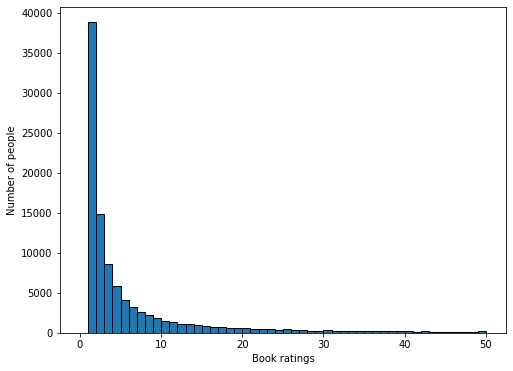

In [0]:
df = ratings.groupby('Book_id').agg({'Reviewer_url':'count'}).reset_index()
plt.figure(figsize=(8,6))
plt.hist(df['Reviewer_url'], range=[0, 50], bins = 50, ec='black')
plt.xlabel('Book ratings')
plt.ylabel('Number of people')
display()

In [0]:
min_book_ratings = 3

more_than_3_reviews = ratings[{'Reviewer_url', 'Book_id'}].groupby('Reviewer_url').agg({'Book_id':'count'}).reset_index()
more_than_3_reviews_list = more_than_3_reviews['Reviewer_url'].loc[more_than_3_reviews['Book_id']>=min_book_ratings]
book_review_popular = ratings.loc[ratings['Reviewer_url'].isin(more_than_3_reviews_list)]
print('Number of unique books: ',book_review_popular['Book_id'].nunique())

Number of unique books: 105459

Based on this exercise, we are left with 105,459 books, which is a decent number of items, so we will continue building the recommender.  We can now proceed with merging of the book data to the ratings data.

One interesting observation that we had by simply browsing the hebban website, is that they do not combine book versions. Thus, if say the book was originally published in 2015 and then re-published in 2020, we will have two different web pages with two sets of ratings. This occur with roughly nineteen thousand books, thus we will aggregate these books to make sure that in the recommender only one version of the book will be visible.
Another little issue that we spotted in the data was related to the encoding, this was fixed using the fix_text function.

In [0]:
books_ratings = pd.merge(left =book_review_popular, right =books ,  on = 'Book_id' , how = 'inner')

#Aggregating book versions
books_new_id = books.groupby(['Book_name','Author_name']).agg({'Book_id':'max'}).reset_index().rename(columns = {'Book_id':'New_book_id'})
books_ratings_new_id = pd.merge(left = books_ratings, right = books_new_id, on = ['Book_name','Author_name'], how = 'inner')
books_ratings_new_id = books_ratings_new_id.drop(columns = 'Book_id')

#fixing encoding
books_ratings_new_id['Reviewer_url'] = books_ratings_new_id['Reviewer_url'].str.strip('"').apply(fix_text)
books_ratings_new_id['Rating'] = books_ratings_new_id['Rating'].str.strip('"')
books_ratings_new_id['Book_name'] = books_ratings_new_id['Book_name'].str.strip('"').apply(fix_text)
books_ratings_new_id['Author_name'] = books_ratings_new_id['Author_name'].str.strip('"').apply(fix_text)

books_ratings_new_id['Reviewer_url'] = books_ratings_new_id['Reviewer_url']
books_ratings_new_id['Rating'] = books_ratings_new_id['Rating'].str.slice(start=2)
books_ratings_new_id['Book_name'] = books_ratings_new_id['Book_name'].str.slice(start=2)
books_ratings_new_id['Author_name'] = books_ratings_new_id['Author_name'].str.slice(start=2)

books_ratings_new_id['Rating'] = books_ratings_new_id['Rating'].astype(int)

books_ratings_new_id=books_ratings_new_id.drop(columns=['Book_url','Author_url', 'Publish_date'])
books_ratings_new_id.head() 

Out[7]:

Rating 
 Reviewer_url 
 Book_name 
 Author_name 
 New_book_id 
 
 
 
 
 0 
 4 
 a2e060012923a7ac0fb56169e7acecb6 
 Maus II 
 Art Spiegelman 
 286 
 
 
 1 
 4 
 ba10aee9112573177a5f3b5b2d588096 
 Maus II 
 Art Spiegelman 
 286 
 
 
 2 
 5 
 c4f18d12c0c861a74c313a72b522c0d5 
 Maus II 
 Art Spiegelman 
 286 
 
 
 3 
 5 
 1c2b6714dddf5a947605dc0d06d575a0 
 Maus II 
 Art Spiegelman 
 286 
 
 
 4 
 5 
 e740a61c06b92d256cdc19ee01487c4d 
 Maus II 
 Art Spiegelman 
 286

After merging and aggregating we are left with a dataset that includes 94.836 books and 37.673 people who rated these books. This is a sufficient amount of data to proceed. We have removed the user names from the overview above, to protect the identity of the raters.
We have now prepared the data and the resulting dataframe consists of rows for every single rating-book combination. Prior to building the recommender itself, we inspect the data for any anomalies that might influence the design of our recommendation  engine.

In [0]:
print('Number of unique books: ',books_ratings_new_id['Book_name'].nunique())
print('Number of unique raters: ', books_ratings_new_id['Reviewer_url'].nunique())
print('Number of unique authors: ', books_ratings_new_id['Author_name'].drop_duplicates().shape[0])

Number of unique books: 94836
Number of unique raters: 37673
Number of unique authors: 36474

#### Data Exploration
Looking at the distribution of book rating. Interestingly, most ratings are positive, with the majority being rated with 4. This implies that the recommender will be biased towards books that are rated positively. Hence, to get the best output from the recommender, the input should also consist of books that the user would rate highly themselves.

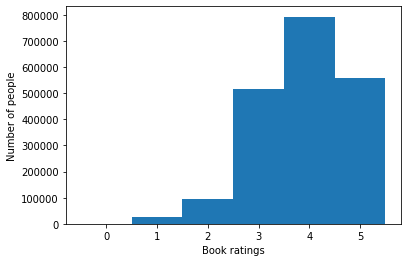

In [0]:
# distribution of rating scores 
bins = np.arange(0, books_ratings_new_id['Rating'].max() + 1.5) - 0.5
plt.hist(books_ratings_new_id['Rating'], bins)
plt.xlabel('Book ratings')
plt.ylabel('Number of people')
plt.show()

One of our initial ideas was to create a recommender at an author-level as well as book-level. However, as we can see from the graph above, most people only rate a single book by the author. Thus, we do not have the evidence that aggregating the data as an author level will give interesting results.

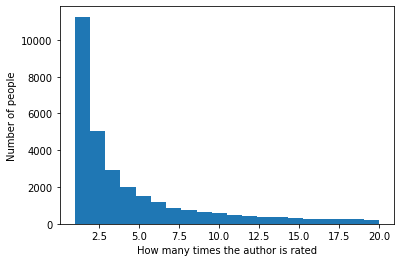

In [0]:
#Distribution of times author is rated
df = books_ratings.groupby(['Author_name']).agg({'Rating': 'count'})
plt.hist(df['Rating'], range=[1, 20], bins = 20)
plt.xlabel('How many times the author is rated')
plt.ylabel('Number of people')
plt.show()

#### Recommendation engine

Now that our data is ready, we can finally get to building the recommender itself. We created a book recommender which is based on the collaborative filtering technique (https://predictivehacks.com/item-based-collaborative-filtering-in-python/). Hereforth, we refer to the data points which correspond to individuals who rated books as people and to the one using the recommender as the user. 
The algorithm returns the best-rated books by the people who have most similar taste to the user. The similarity is assessed by comparing the rating scores of the user to those of all people in the data. 
The recommender takes as input the ratings of the user and  the percentage of the data to be used for prediction. The predictions should include three columns: the title of the book, the author of the book and the rating itself. It is advised to rate the books on the scale from 1 to 5, where 1 is 'I did not like the book' and 5 'I loved the book'. 
Further there are three optional inputs: number of books to return, number of users to compare and the number of reviews. The Number of books to return refers to the number of recommended books that a user wishes to be displayed. This variable is set to 10. The number of users to compare to is the number of users that will be selected based on the similarity measurement in order to create the 10 (or any other number that the user selects) recommended books. The final input, namely the number of reviews refers to the minimum number of reviews that the book should have in order to be displayed. This is referred to the number of reviews by the most similar people. If this input is kept at 1, the recommender is heavily influenced by outliers. However if the number of users to compare to is kept low while the number of reviews is kept high, it is possible that less than the desired number if books will be returned since there won't be enough books in common.

The training data is pre-processed which includes cleaning and reshaping. Thus the training set consists of a matrix which has unique people as rows, unique books as columns and book ratings as elements. In case that the person had more than one rating of the same book, only the latest is taken into account. If a person did not rate a book then the score is set to 0. Since the lowest rating for the book is 1, there is no confusion between the books that were not rated and those that were rated poorly.

The recommender consists of the following steps:
 1. Transforming and appending the information supplied by the user to the training data. 
 2. Creating the references for both books and raters equal to their row/column, later to be used to be able to find back the books/raters in the data
 3. Create an empty sparse matrix equal in dimensions to the data and fill it with the book ratings. We chose to work with sparse matrices since most people have rated but a few books, so most elements of the matrix are in fact zeros. This is not necessarily needed, but it greatly improves the speed of calculation. 
 4. Create sparse vector with the ratings of the user.
 5. Quontify the similarity between the user and all other people in the data. This is done wuth the cosine similarity. 
 6. Now that we calculated the similarity, we can select top 100(of the number specified by the user) people in the training data who had most similar books ratings to the user, based on cosine similarity. At this step we also filter the points based on the minimum number of books that need to match. 
 7. Select the books that were rated by the top 100 but not by the user him/herself and calculate the average rating of the books based on the data of the top 100.
 8. Select the number of the top-rated books that the user wishes to receive and display the results.

In [0]:
def recommender(ratings_of_user, sample_size, Number_of_books_to_return = 10, Number_of_users_to_compare = 100, NrReviews = 1):

  ###Step 1: Transforming and appending the information supplied by the user to the training data
  books_ratings_sample = books_ratings_new_id.sample(frac = sample_size).copy()
  data_to_restructure = books_ratings_sample[{'Book_name', 'Rating', 'Reviewer_url', 'New_book_id'}].append(ratings_of_user[{'Book_name', 'Rating', 'Reviewer_url', 'New_book_id'}]).copy() #appending user for whom the prediction is to be made 
  df = data_to_restructure.groupby(['Book_name', 'New_book_id','Reviewer_url']).agg({'Rating':'count'}).reset_index()
  data_to_pivot = pd.merge(left = data_to_restructure, right = df , on =['Book_name', 'New_book_id','Reviewer_url'] , how = 'inner')
  data_to_pivot_unique_rows = data_to_pivot.loc[data_to_pivot['Rating_y']==1].copy()
  
  ###Step 2: Creating the references for both books and raters equal to their row/column, later to be used to be able to find back the books/raters in the data
  #enumerate books and reviewers
  lb_make = LabelEncoder()
  data_to_pivot_unique_rows.loc[:,'Book_code']=lb_make.fit_transform(data_to_pivot_unique_rows['New_book_id'])
  data_to_pivot_unique_rows.loc[:,'Reviewer_code']=lb_make.fit_transform(data_to_pivot_unique_rows['Reviewer_url'])
  
  #unique users
  unique_users = data_to_pivot_unique_rows['Reviewer_url'].sort_values().unique()
  #unique books
  unique_books = data_to_pivot_unique_rows['New_book_id'].sort_values().unique()
  
  ###Step 3: Create an empty sparse matrix equal in dimensions to the data and fill it with the book ratings
  #matrix with unique users as rows and unique books as columns
  empty_matrix = np.zeros((unique_users.shape[0],unique_books.shape[0]),dtype='uint8')
  
  #fill the empty matrix with corresponding ratings per user per book
  for i in data_to_pivot_unique_rows.itertuples():
    empty_matrix[i.Reviewer_code, i.Book_code] = i.Rating_x
    
  ###Step 4: Create sparse vector with the ratings of the user
  #the index of a the person to predict in an array
  user_to_predict = ratings_of_user.Reviewer_url.iloc[1]
  index_predict = np.where(unique_users == user_to_predict)[0][0]
  
  ###Step 5: Quontify the similarity between the user and all all other people in the data. 
  A_sparse = sparse.csr_matrix(empty_matrix)
  similarities = cosine_similarity(A_sparse, sparse.csr_matrix(empty_matrix[index_predict]))
  
  ###Step 6: Select top Number_of_users_to_compare people in the training data who had most similar books ratings to the user
  similar_users = pd.DataFrame({'Users' : unique_users,
             'Similarity_index' : similarities.flatten()})
  
  #remove a person for whom the predictions were made; sort and grab top 10 most similar users
  similar_users = similar_users.drop([index_predict])
  similar_top10_users = similar_users.sort_values('Similarity_index', ascending = False).head(n=Number_of_users_to_compare+1)
  
  ###Step 7: Select the books that were rated by the top Number_of_users_to_compare but not by the user him/herself and calculate the average rating of the books based on the data of the top 100.
  Books_of_similar_users = data_to_pivot_unique_rows.loc[(data_to_pivot_unique_rows.Reviewer_url.isin(similar_top10_users.Users)) &
                                                         (~data_to_pivot_unique_rows.New_book_id.isin(ratings_of_user.New_book_id))]
  
  Book_rated = Books_of_similar_users.groupby('New_book_id').agg({'Rating_x':['mean', 'count']}).reset_index()
  Book_rated.columns = ['New_book_id', 'Rating_mean', 'Rating_count'] 
  books_temp = Book_rated.sort_values('Rating_mean', ascending = False).reset_index()
  Books_to_present = pd.merge(left = books_ratings_sample, right = books_temp, on = 'New_book_id', how = 'inner')
  Books_to_present_unique_records = Books_to_present[['Book_name', 'Author_name', 'Rating_mean', 'Rating_count']].drop_duplicates().copy()
  Books_to_present_unique_records.loc[:,'author_score'] = Books_to_present_unique_records.groupby(['Author_name'])['Rating_mean'].rank(method ='first', ascending=False)
  
  ###Step 8: Select the number of the top-rated books that the user wishes to receive and display the results.
  Books_to_return = Books_to_present_unique_records.loc[(Books_to_present_unique_records.author_score==1) & (Books_to_present_unique_records.Rating_count >=NrReviews)].sort_values('Rating_mean', ascending = False).head(n=Number_of_books_to_return).copy()
  Books_to_return2 = Books_to_return.drop(columns=['author_score', 'Rating_count'])
  return Books_to_return2#[['Book_name','Author_name']]

Now, let us demonstrate how the recommender works. We will use the data of one of our colleague (Anya) and use her ratings to derive two recommendations. We make a dataframe with her ratings and combine it with the books data in order to obtain book identifiers.

In [0]:
books = ['De reisgenoten','Diep Werk','Emma','De beer en de nachtegaal','Good Vibes, Good Life','Pilaren van de aarde / De kathedraal','De pest','The Master and Margarita','1q84 - de complete trilogie','To kill a Mockingbird', 'Gone with the wind']
authors = ['J.R.R. Tolkien','Cal Newport','Jane Austen','Katherine Arden','Vex King','Ken Follett','Albert Camus','Mikhail Bulgakov','Haruki Murakami','Harper Lee','Margaret Mitchell']
ratings = [4,5,5,4,4,3,4,5,5,5,5]
name = 'Anya'
Anya = {'Book_name':books, 'Author_name': authors,  'Reviewer_url':name, 'Rating':ratings}
Anya_df = pd.DataFrame(data=Anya)
Anya_df_ready = pd.merge(left = Anya_df, right =books_ratings_new_id[['Book_name','Author_name','New_book_id']] , on = ['Book_name','Author_name'] , how = 'left').drop_duplicates()

Below you can see that not all books which she supplied were found in the data. Sadly a book by Vex King 'Good vibes, good life' was not found. It is important to have a sufficient number of books to be able to produce a good recommendation. Perhaps we should have given a set of books to rate, which are definitely in the data. However such an approach would make it less engaging for the user. Not to mention, our recommender is biased towards positively rated data, thus the set our books that the person is rating should include the books that they enjoyed.

In [0]:
Anya_df_ready

Out[60]:

Book_name 
 Author_name 
 Reviewer_url 
 Rating 
 New_book_id 
 
 
 
 
 0 
 De reisgenoten 
 J.R.R. Tolkien 
 Anya 
 4 
 222654 
 
 
 667 
 Diep Werk 
 Cal Newport 
 Anya 
 5 
 273043 
 
 
 677 
 Emma 
 Jane Austen 
 Anya 
 5 
 69133 
 
 
 853 
 De beer en de nachtegaal 
 Katherine Arden 
 Anya 
 4 
 366569 
 
 
 1074 
 Good Vibes, Good Life 
 Vex King 
 Anya 
 4 
 NaN 
 
 
 1075 
 Pilaren van de aarde / De kathedraal 
 Ken Follett 
 Anya 
 3 
 94115 
 
 
 1960 
 De pest 
 Albert Camus 
 Anya 
 4 
 123976 
 
 
 2444 
 The Master and Margarita 
 Mikhail Bulgakov 
 Anya 
 5 
 367599 
 
 
 2452 
 1q84 - de complete trilogie 
 Haruki Murakami 
 Anya 
 5 
 310941 
 
 
 2847 
 To kill a Mockingbird 
 Harper Lee 
 Anya 
 5 
 374779 
 
 
 3015 
 Gone with the wind 
 Margaret Mitchell 
 Anya 
 5 
 298088

As mentioned before, we run a test with the different parameters:
- x = the number of most similar people 
- N = the minimum number of times a book must be reviewed by the top x people to be part of the recommendations

To be less sensitive for outliers in our recommendations we wanted to increase the number of times a book must be reviewed (N). We can only do this if we also increase the number of reviewers we take into account (x). We tested with values for N from 1 to 3 and therefore we must vary x between 10 and 100 to have enough recommendations.

Luckily, our colleagues wanted to act as a test group for this experiment. Based on their recommendation of 10 books they choose themselves, we created multiple recommendation lists per person with the book recommender. By marking their favourite list, we can give you our opinion on the best parameters. 

First we have to remark that our colleagues did not all agree on the best parameters. In general we can say it's better to recommend books which are reviewed more than once by your top x group. A higher N is not always better as our colleagues marked the recommendations with N=3 as 'too general' and 'only bestseller'. 

Choosing the preferred values for N and x depends on the tradeoff that one makes between receiving reliable recommendations that might be quite obvious or receiving less stable recommendations that are more surprising. Thus, someone that wants to receive a list with new and surprising books will have to settle for slightly less reliable recommendations. With our data and in our test group the options N=2 and X=50 plus N=2 and X=100 where the best options. Let's have a look at Anya's lists with those parameters.

In [0]:
print(recommender(Anya_df_ready, 1, Number_of_users_to_compare=50, NrReviews=2).to_string(index=False))

Book_name Author_name Rating_mean
 Het huis van de moskee Kader Abdolah 5.000000
 De twee torens J.R.R. Tolkien 5.000000
 De ontdekking van de hemel Harry Mulisch 5.000000
 Gevoel en verstand / Sense and sensibility Jane Austen 5.000000
 Ik ben Pelgrim Terry Hayes 4.666667
 Het smelt Lize Spit 4.500000
 Grand Hotel Europa Ilja Leonard Pfeijffer 4.500000
 De donkere kamer van Damokles Willem Frederik Hermans 4.333333
 Haar naam was Sarah Tatiana de Rosnay 4.000000
 Een klein leven Hanya Yanagihara 4.000000

In [0]:
print(recommender(Anya_df_ready, 1, Number_of_users_to_compare=100, NrReviews=2).to_string(index=False))

Book_name Author_name Rating_mean
 Honderd jaar eenzaamheid Gabriel Garc\xeda M\xe1rquez 5.0
 Trots en vooroordeel / Pride and Prejudice Jane Austen 5.0
 De verborgen geschiedenis Donna Tartt 5.0
 De niet verhoorde gebeden van Jacob de Zoet David Mitchell 5.0
 Harry Potter en de Steen der Wijzen J.K. Rowling 5.0
 Duizend schitterende zonnen Khaled Hosseini 5.0
 1q84 boek 1 Haruki Murakami 5.0
 Het huis van de moskee Kader Abdolah 5.0
 De naam van de roos Umberto Eco 5.0
 De Millennium trilogie Stieg Larsson 5.0

The average rating is better, as for most colleagues, with a higher x (4.97 versus 4.50). We see the same behaviour in the output for Anya.
Hereby we have to remark that is depends on your taste. When you tend to enjoy reading the bestsellers, you should get the best results with a small x.

Our team is very proud to have been able to gather our own data and build a book recommender from scratch. It was a journey which we started wanting to practice our Python skills in a completely different settings. In fact the most interesting part was deciding what variables to use. In fact, the first decision we had to take before we even started building the recommender. We described above how we had to omit the books that were rated by only a couple of people.
Secondly, we put a lot of thought and effort into figuring out the best number of people to be compared with and the overlap between the books' ratings. As you saw, we don't actually have an answer to what is the best combination of these parameters and instead we think that playing around is best depending on what kind of books you would like to receive.

Would we change anything about the journey? Perhaps if we were to create our recommender from scratch, we would look for the data that is not positively skewed and would include book genres. This would allow to tailor predictions to the wishes of the user. Another data source can solve this.